In [270]:
%matplotlib inline
import os
import sys
import itertools
import imp
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from bisect import bisect_left


import matplotlib
import matplotlib.pyplot as plt
import IPython.html.widgets as weejet

import climatools.units as climaunits

imp.reload(climaunits)

# get spectral band information for clirad and rrtmg
import rtmtools.clirad.sw.info as cliradswinfo
import rtmtools.clirad.lw.info as cliradlwinfo
import rtmtools.rrtmg.sw.info as rrtmgswinfo
import rtmtools.rrtmg.lw.info as rrtmglwinfo

from IPython.display import HTML

matplotlib.rcParams.update({'xtick.direction': 'out',
                            'xtick.major.size': 7, 'xtick.major.width': 1,
                            'xtick.minor.size': 4, 'xtick.minor.width': 1,
                           'ytick.direction': 'out',
                           'font.size': 15})

In [235]:
def get_fpath():
    return '/nuwa_cluster/home/jackyu/climate_models/scam/examples/ARM95/\
cam5_noavg_LW_rrtmgMcICA_rrtmgMcICAaer_SW_rrtmgMcICA_rrtmgMcICAaer/aer_opts.dat'




In [236]:
def get_clirad_midband_wavenumbers():
    wavenumbers = [.5 * sum(limit) \
                   for iband, limits in cliradswinfo.wavenumber_bands().items() \
                   for limit in limits]
    return sorted(wavenumbers)

    
def get_rrtmg_midband_wavenumbers():
    return [.5 * sum(limits[0]) for iband, limits in rrtmgswinfo.wavenumber_bands().items()]


def preprocess_data():
    df = pd.read_csv(get_fpath(), sep = r'\s+', index_col = [0, 1, 2, 3])
    df.index = df.index.droplevel(1)
    df = df.unstack(1)
    df.index.set_levels(get_rrtmg_midband_wavenumbers(), level=1, inplace = True)
    df.index.rename(['nstep', 'midband wavenumber'], inplace = True)
    df.columns = df.columns.droplevel(0)
    return df


def quick_plt(df, nstep = 500, layers = None):
    ax = df.loc[(nstep, slice(None))].sort_index().loc[:, layers]\
    .plot(figsize = (10, 11), marker = 'x')
    
    ax.set_xscale('log')
    ax.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    
    ax.set_yscale('log')
    ax.set_ylabel(r'$\tau$', fontsize = 17.)
    ax.set_ylim((0, .02))
    
    ax.legend(loc = 'upper left')
    
    
    return




In [237]:
df = preprocess_data()

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/pandas/core/index.py:4072: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


# Aerosol optical properties

RRTMG-SW 'extinction optical depth' for 31 atmospheric layers at some model timestep.

The wavenumbers are taken to be the in the middle of each spectral band.

<function __main__.<lambda>>

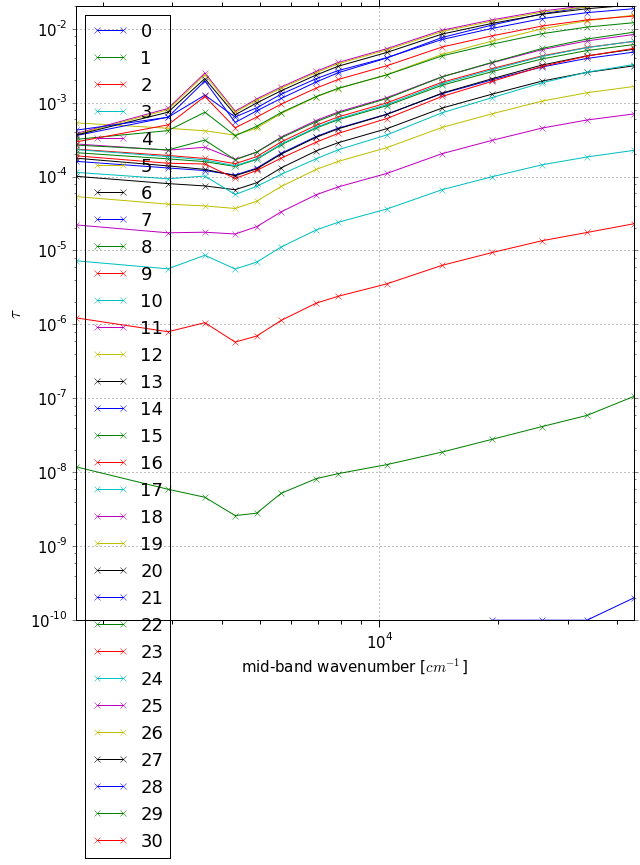

In [238]:
weejet.interact(lambda nstep: \
                quick_plt(df, nstep = nstep, layers = range(30 + 1)),
               nstep = (0, 1225, 1))

### RRTMG's extinction fitted onto CLIRAD

#### Fitted using scipy's InterpolatedUnivariateSpline() using a univariate spline with order = 1.

In [324]:
def fit_extinction_onto_CLIRAD(sample):
    # fit the sample using InterpolatedUnivariateSpline
    order = 1
    f = InterpolatedUnivariateSpline(sample.index.values, sample.values, 
                                 k = order)

    # predict for CLIRAD-SW's wavenumbers, return in same format as sample
    x = get_clirad_midband_wavenumbers()
    prediction = pd.Series(f(x), index = x)
    return sample, prediction


def plt_extinction_sample_and_fit(nstep = 500, layer = 20):
    # get a sample of (wavenumber, extinction)
    sample = df.loc[(nstep, slice(None))].sort_index().loc[:, layer]
    sample, prediction = fit_extinction_onto_CLIRAD(sample)
    
    sample.name = 'RRTMG'
    prediction.name = 'CLIRAD'
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, 
                       figsize = (6, 6), )
    sample.plot(ax = axs, marker = 'x', linestyle = 'None', label = 'RRTMG')
    prediction.plot(ax = axs, marker = '.', label = 'CLIRAD')

    axs.set_yscale('log')
    axs.set_ylabel(r'$\tau$', fontsize = 15.)
    axs.set_ylim((1e-5, 1e-2))
    
    axs.set_xscale('log')
    axs.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    axs.set_xlim((0, 45000))
    
    axs.legend(loc = 'upper left')
    
    return fig, axs

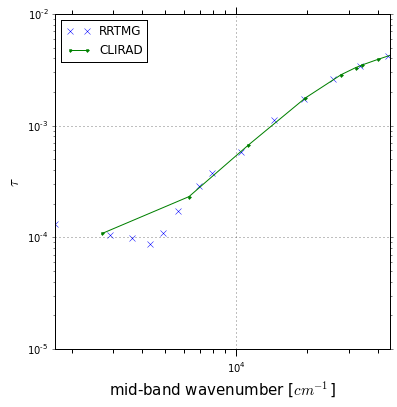

In [441]:
weejet.interact(plt_extinction_sample_and_fit,
               nstep = (0, 1225, 1), layer = (0, 30, 1))

#### Fitted using cubic spline subroutines from Numerical Recipes (3.3 Cubic Spline Interpolation)

In [213]:
with open('cubicsplint.f90', mode = 'r', encoding = 'utf-8') as file:
    content = file.read()

#print(content)

In [239]:
!ls *.f90 *.so

cubic2.cpython-34m.so  cubic.cpython-34m.so  cubicsplint.f90


In [241]:
!rm cubic.cpython-34m.so
#del cubic

!f2py3 -c -m cubic cubicsplint.f90 > f2py3.log

import cubic
imp.reload(cubic)

rm: cannot remove `cubic.cpython-34m.so': No such file or directory


<module 'cubic' from '/nuwa_cluster/home/jackyu/climate_models/scam/SCAM_radiation_notebooks/cubic.cpython-34m.so'>

In [246]:
def fit_extinction_onto_CLIRAD_f2py(sample):
    '''
    This fits using cubic spline subroutines from Numerical Recipes
    '''
    y2 = cubic.spline(sample.index.values, sample.values, 2e30, 2e30)
    cubic_spline_fit = np.vectorize(lambda x: cubic.splint(sample.index.values, sample.values, y2, x))
    values_clirad = cubic_spline_fit(get_clirad_midband_wavenumbers())
    prediction = pd.Series(values_clirad, index = get_clirad_midband_wavenumbers())
    return sample, prediction



def plt_extinction_sample_and_fit_f2py(nstep = 500, layer = 20):
    # get a sample of (wavenumber, extinction)
    sample = df.loc[(nstep, slice(None))].sort_index().loc[:, layer]
    sample, prediction = fit_extinction_onto_CLIRAD_f2py(sample)
    
    sample.name = 'RRTMG'
    prediction.name = 'CLIRAD'
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, 
                       figsize = (6, 6), )
    sample.plot(ax = axs, marker = 'x', linestyle = 'None', label = 'RRTMG')
    prediction.plot(ax = axs, marker = '.', label = 'CLIRAD')

    axs.set_yscale('log')
    axs.set_ylabel(r'$\tau$', fontsize = 15.)
    axs.set_ylim((1e-5, 1e-2))
    
    axs.set_xscale('log')
    axs.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    axs.set_xlim((0, 45000))
    
    axs.legend(loc = 'upper left')
    
    return fig, axs


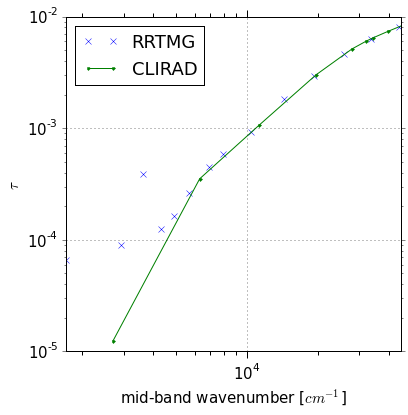

In [245]:
weejet.interact(plt_extinction_sample_and_fit_f2py,\
                nstep = (0, 1225, 1), layer = (0, 30, 1))

#### Fitted using Angstrom Exponent

https://en.wikipedia.org/wiki/Angstrom_exponent

In [707]:
def angstrom_exponent(lam1, lam2, tau1, tau2):
    '''
    returns Angstrom Exponent given two sets of wavelengths and optical depths
    '''
    return - np.log10(tau1 / tau2) / np.log10(lam1 / lam2)




def tau_from_angstrom_exponent(lam1, lam2, tau1, alpha):
    '''
    use Angstrom exponent to determine the optical depth at some wavelength, given the optical depth at some other
    INPUT:
    lam1  --- wavelength at which optical depth is known
    lam2  --- wavelength at which optical depth is to be determined
    tau1  --- optical depth at lam1
    alpha --- Angstrom coeffecient
    OUTPUT:
    tau2  --- optical depth at lam2
    '''
    return tau1 * (lam2 / lam1)**(- alpha)




def angstrom_for_rrtmg_midbands(sample):
    '''
    returns Angstrom Exponents based on adjacent mid-band spectral wavenumbers
    of RRTMG\'s spectral bands.  So, if there are 4 spectral bands, this returns
    3 wavelengths and 3 Angtrom exponents.
    INPUT:
    sample --- [Pandas DataFrame]
               midband wavelength --- wavelength in the middle of spectral bands
               tau --- optical depths 
    OUTPUT:
    [Pandas DataFrame]
    alpha wavelength --- wavelengths halfway between adjacent midband wavelengths
    alpha --- Angstrom exponents 
    '''
    wavelengths = sample['midband wavelength'].values
    values = sample['tau'].values
    Nlam = len(wavelengths)
    Na = Nlam - 1
    lams, angstrom_exponents = [], []
    for k in range(Na):
        lam1, lam2 = wavelengths[k], wavelengths[k + 1]
        tau1, tau2 = values[k], values[k + 1]
        lam_avg = .5 * (lam1 + lam2)
        A = angstrom_exponent(lam1, lam2, tau1, tau2)
        lams.append(lam_avg)
        angstrom_exponents.append(A)
        
    return pd.DataFrame({'alpha': np.array(angstrom_exponents), 'alpha wavelength': np.array(lams)})




def find_closest(A, target):
    '''
    For each value in TARGET, find the index of the value in A that is closest to it.
    INPUT:
    A --- [sorted 1D numpy array] 
    target --- [1D numpy array]
    '''
    # A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A) - 1)
    left = A[idx - 1]
    right = A[idx]
    idx -= target - left < right - target
    return idx




def interp_angstrom(sample, angstrom, predict):
    '''
    interpolate sample optical properties using Angstrom exponents
    INPUT:
    sample --- [Pandas DataFrame]
                midband wavelength --- wavelength at middle of spectral bands
                tau --- opetical depth
    angstrom --- [Pandas DataFrame]
                  alpha wavelength --- wavelength halfway between wavelengths in 'midband wavelength'
                  alpha --- Angstrom exponent
    predict --- [Pandas DataFrame]
                 midband wavelength --- wavelength at middle of spectral bands
    OUTPUT:
    predict --- [Pandas DataFrame]
                 midband wavelength --- same as input
                 tau --- optical depth
    '''
    idx_closest_lams_angstrom = find_closest(angstrom['alpha wavelength'].values, 
                                             predict['midband wavelength'].values)
    idx_closest_lams_sample = find_closest(sample['midband wavelength'].values, 
                                           predict['midband wavelength'].values)
    
    predict_taus = tau_from_angstrom_exponent(sample['midband wavelength'].values[idx_closest_lams_sample], 
                                              predict['midband wavelength'].values,
                                              sample['tau'].values[idx_closest_lams_sample],
                                              angstrom['alpha'].values[idx_closest_lams_angstrom])
    predict['tau'] = predict_taus
    return predict
    

In [709]:
nstep, layer = 600, 20

print('RRTMG optical depth at nstep = {}, layer = {}'.format(nstep, layer))

sample = df.loc[(nstep, slice(None))].loc[:, layer]
sample = pd.DataFrame(sample)
sample.columns = ['tau']
sample.reset_index(inplace = True)
sample['midband wavelength'] = list(map(climaunits.wavenumber_to_nanometres, sample['midband wavenumber']))
sample = sample.sort('midband wavelength')

sample

RRTMG optical depth at nstep = 600, layer = 20


,midband wavenumber,tau,midband wavelength
12,44000,0.002859,227.272727
11,33500,0.002198,298.507463
10,25825,0.001560,387.221684
9,19325,0.000955,517.464424
8,14425,0.000573,693.240901
7,10450,0.000277,956.937799
6,7875,0.000172,1269.841270
5,6925,0.000130,1444.043321
4,5650,0.000077,1769.911504
3,4900,0.000047,2040.816327


In [708]:
print('CLIRAD wavenumbers and wavelengths')

predict = pd.DataFrame({'midband wavenumber': get_clirad_midband_wavenumbers(),
                       'midband wavelength': list(map(climaunits.wavenumber_to_nanometres, get_clirad_midband_wavenumbers()))})

predict

CLIRAD wavenumbers and wavelengths


,midband wavelength,midband wavenumber
0,3703.703704,2700.0
1,1587.301587,6300.0
2,889.679715,11240.0
3,509.087207,19643.0
4,358.615743,27885.0
5,311.997878,32051.5
6,292.307917,34210.5
7,251.471106,39766.0
8,196.877522,50793.0


In [710]:
print('Angstrom exponents calculated from RRTMG optical depths and midband wavelengths')


angstrom = angstrom_for_rrtmg_midbands(sample)

angstrom

Angstrom exponents calculated from RRTMG optical depths and midband wavelengths


,alpha,alpha wavelength
0,0.963950,262.890095
1,1.317748,342.864574
2,1.692948,452.343054
3,1.743611,605.352663
4,2.256131,825.089350
5,1.683562,1113.389534
6,2.174476,1356.942296
7,2.592855,1606.977413
8,3.519312,1905.363915
9,1.653385,2176.477527


In [711]:
print('CLIRAD optical depths obtained from above Angstrom exponents')

predict = interp_angstrom(sample, angstrom, predict)



predict

CLIRAD optical depths obtained from above Angstrom exponents


,midband wavelength,midband wavenumber,tau
0,3703.703704,2700.0,0.000074
1,1587.301587,6300.0,0.000102
2,889.679715,11240.0,0.000327
3,509.087207,19643.0,0.000982
4,358.615743,27885.0,0.001726
5,311.997878,32051.5,0.002074
6,292.307917,34210.5,0.002243
7,251.471106,39766.0,0.002593
8,196.877522,50793.0,0.003283


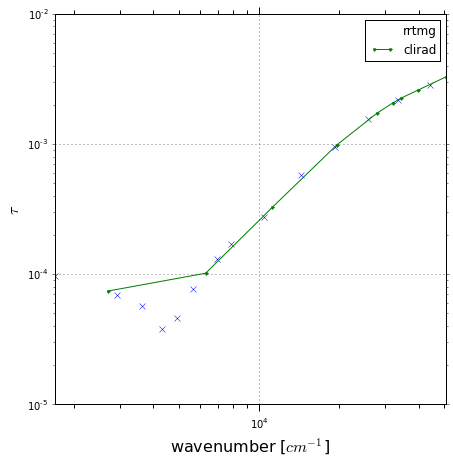

In [717]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 7))

ax = sample.sort('midband wavenumber').plot(ax = ax, x = 'midband wavenumber', y = 'tau', label = 'rrtmg',
                                      linestyle = 'None', marker = 'x')
ax = predict.sort('midband wavenumber').plot(ax = ax, x = 'midband wavenumber', y = 'tau', label = 'clirad',
                                             marker = '.')

ax.set_xscale('log')
ax.set_xlabel(r'wavenumber [$cm^{-1}$]', fontsize = 16)

ax.set_yscale('log')
ax.set_ylabel(r'$\tau$', fontsize = 16)

# Optical properties inside deledd() when aerosol is switched on

In [2]:
def get_deledd_interm_vars(isuv = 0, isclear = 0, isbeam = 0):
    rundir = '../examples/ARM95/cam5_noavg_LW_rrtmgMcICA_CLIRADaer_SW_rrtmgMcICA_CLIRADaer/'
    datpath = os.path.join(rundir, \
                           'debug_deledd_isuv_{}_isclear_{}_isbeam_{}.dat'\
                           .format(isuv, isclear, isbeam))
    df = pd.read_csv(datpath, sep = r'\s+')
    # because we know that the dat files only contain data for 1 column and 1 nstep, we drop these as indices
    df = df.drop(['icol', 'nstep'], axis = 1)
    # only the spectral band index and atmosphere layer index are used as indices
    df = df.set_index(['ib', 'ilev'])
    return df


def print_situation(isuv = 0, isclear = 0, isbeam = 0):
    print('uv' if isuv else 'ir', ',' , 'clear sky' if isclear else 'cloudy', ',', 'beam' if isbeam else 'diffuse')
    
    
def print_stats_summary(isuv = 0, isclear = 0, isbeam = 0, iband = 1):
    df = get_deledd_interm_vars(isuv = isuv, isclear = isclear, isbeam = isbeam)
    print(df.loc[(iband, slice(None)), :].describe().loc[['min', 'max']])

In [214]:
def print_debug_summary():
    note = '''soluv() is called before solir() in sorad().  Floating error raised inside soluv(), so solir() had not
even been called.  


Inside soluv(), deledd() is called four times for each spectral band, for all combinations of 
clear sky/cloudy sky and beam/diffuse radiation.

Here we look at the nstep at which the floating error occurs.  At this nstep, (clear sky, beam), 
(clear sky, diffuse) and (cloudy sky, diffuse) are ok for the first two spectral bands.  

But for (cloudy sky, beam), deledd() fails in the second spectral band.

Below are some basic stats summarising the intermediate variable used before the floating error occurs when 
square-rooting a negative number.


Looking at the case where floating error arises (uv, cloudy, beam, iband = 2), it appear that the maximum value of g0 is about 2, 
and the minimum value of taup is -1.  These might be the cause of the problems.
'''

    print(note)

    isuv = 1

    print(2 * '\n')

    isclear, isbeam = 1, 1
    print_situation(isuv = isuv, isclear = isclear, isbeam = isbeam)
    print()
    iband = 1
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)
    print()
    iband = 2
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)

    print(2 * '\n')

    isclear, isbeam = 1, 0
    print_situation(isuv = isuv, isclear = isclear, isbeam = isbeam)
    print()
    iband = 1
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)
    print()
    iband = 2
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)


    print(2 * '\n')


    isclear, isbeam = 0, 1
    print_situation(isuv = isuv, isclear = isclear, isbeam = isbeam)
    print()
    iband = 1
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)
    print()
    iband = 2
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)


    print(2 * '\n')


    isclear, isbeam = 0, 0
    print_situation(isuv = isuv, isclear = isclear, isbeam = isbeam)
    print()
    iband = 1
    print('iband =', iband)
    print_stats_summary(isuv = isuv, isclear = isclear, isbeam = isbeam, iband = iband)


    print(2 * '\n')
    
#print_debug_summary()

# RRTMG and CLIRAD optical properties: from subroutine aer_optics_rrtmg_to_clirad()


These are the $\tau_{ext}$, $\tau_{\omega}$ and $\tau_{g}$, sorted by mid-band wavenumbers or by band index, written out from subroutine aer_optics_rrtmg_to_clirad() during an ARM95 SCAM run.

There is a set of values for RRTMG, and another for CLIRAD.  CLIRAD values are interpolated from RRTMG's, using a cubic splint routine gotten from Numerical Recipes.  

It has already been shown for a particular case that this routine, when compiled using f2py, works reasonably.



In [320]:
def aero_opts_AER_OPTICS_RRTMG_TO_CLIRAD_filepaths(model = 'rrtmg', \
                                                   sortedby = 'w'):
    rundir = '../examples/ARM95/\
cam5_noavg_LW_rrtmgMcICA_CLIRADaer_SW_rrtmgMcICA_CLIRADaer'
    filename = '{}_aero_opts_{}sorted.dat'.format(model, sortedby)
    return os.path.join(rundir, filename)



def load_AER_OPTICS_RRTMG_TO_CLIRAD_data(model = 'rrtmg', \
                                        sortedby = 'w'):
    fpath = aero_opts_AER_OPTICS_RRTMG_TO_\
CLIRAD_filepaths(model = model, sortedby = sortedby)
    
    df = pd.read_csv(fpath, sep = r'\s+')
    
    # get rid of nstep and sounding indices since there is only one
    # and set layer index and spectral index as a MultiIndex for dataframe
    df = df.drop(['nstep', 'icol'], axis = 1).set_index(['ilay', 'ib'])
    
    # replace spectral index with mid-band wavenumbers if sorted by wavenumbers
    if sortedby == 'w':
        if model == 'rrtmg':
            df.index.set_levels(sorted(get_rrtmg_midband_wavenumbers()),\
                               level = 1, inplace = True)
        elif model == 'clirad':
            df.index.set_levels(sorted(get_clirad_midband_wavenumbers()),\
                               level = 1, inplace = True)
        else:
            raise ValueError('model must be one of rrtmg and clirad.')
        
        df.index.rename(['ilay', 'mid-band wavenubmer'], inplace = True)

    elif sortedby == 'b':
        pass
    else: 
        raise ValueError('sortedby must be either w or b')
        
    
    return df



def stats_summary_AER_OPTICS_RRTMG_TO_CLIRAD():
    
    models = ['rrtmg', 'clirad']
    sortedby = ['w', 'b']
    
    combos = itertools.product(models, sortedby)
    
    for model, sortedby in combos:
        print()
        print('model: ', model, '  ', 'sortedby: ', 'wavenumber' if sortedby == 'w' else 'band index')
        df = load_AER_OPTICS_RRTMG_TO_CLIRAD_data(model = model, sortedby = sortedby)
        print(df.describe())



def plt_AER_OPTICS_RRTMG_to_CLIRAD(model = 'rrtmg',
                                   sortedby = 'b',
                                   optical_prop = 'tau',
                                  layers = None):
    if layers == None:
        return
    
    df = load_AER_OPTICS_RRTMG_TO_CLIRAD_data(model=model, 
                                              sortedby=sortedby)
    df = df.loc[(layers, slice(None)), optical_prop].unstack(0)
    
    ncols = 3
    
    nrows = int(np.ceil(len(layers) / ncols))
    
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols,
                           sharex = True,
                           figsize = (4 * ncols + 1, 4 * nrows ))
    
        
    for ax, (layer, dfl) in zip(axs.flatten(), df.iteritems()):
        
        cs = ax.plot(dfl.index.values, dfl.values, label = 'layer {}'.format(layer))
        
        ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
        
        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
        
        ax.legend(loc = 'best')
        
    
    plt.figtext(x = .5, y = .05, 
                s = '{}'.format(dfl.index.names[0]), fontsize = 15)
    
    plt.figtext(x = .05, y = .5, s = '{}'.format(optical_prop), rotation = 90.,
               fontsize = 15, 
                horizontalalignment = 'center', verticalalignment = 'center')
       
    fig.suptitle('{}'.format(model), fontsize = 15)
    

    
def plt_RRTMG_vs_CLIRAD(optical_prop = 'tau', layers = None):
    
    if layers == None:
        return
    
    # only makes sense to compare when sorted by wavenumbers
    dfclirad = load_AER_OPTICS_RRTMG_TO_CLIRAD_data(model = 'clirad',
                                                   sortedby = 'w')
    
    dfrrtmg = load_AER_OPTICS_RRTMG_TO_CLIRAD_data(model = 'rrtmg',
                                                  sortedby = 'w')
    
    dfs = [dfclirad] + [dfrrtmg]
    
    dfs = [df.loc[(layers, slice(None)), optical_prop].unstack(0) for df in dfs]
    

    
    #plot
    
    labels = ['CLIRAD', 'RRTMG'] + ['cliradx']
    linestyles = ['--', '--'] + ['--']
    colours = ['b', 'g'] + ['r']
    markers = ['.', '.'] + ['.']
    
    ncols = 3
    nrows = int(np.ceil(len(layers) / ncols))
    
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols,
                           figsize = (5 * ncols, 3 * nrows + 1), 
                           sharex = True)
    
    for ax, layer in zip(axs.flatten(), dfs[0]):
        
        dfls = [df[layer] for df in dfs]
        
        # interpolate from RRTMG to CLIRAD using f2py cubic splint function from above
        sample, prediction = fit_extinction_onto_CLIRAD_f2py(dfls[1])
        
        dfls.append(prediction)
        
        xys = itertools.chain(*((dfl.index.values, dfl.values) for dfl in dfls))
        
        lines = ax.plot(*xys)
        
        [plt.setp(line, linestyle = 'None', color = colour, 
                  label = label, marker = marker) \
         for line, linestyle, colour, label, marker \
         in zip(lines, linestyles, colours, labels, markers)]
        
        ax.legend(loc = 'best')
        ax.set_title('layer {}'.format(layer))
#        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_yscale('log')
        ax.yaxis.grid(b = True)
        
#        ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_xscale('log')
        ax.xaxis.grid(b = True)   
        

    fig.suptitle(optical_prop)
    
    fig.text(x = .02, y = .5, s = '{}'.format(optical_prop), 
             fontsize = 15, rotation = 90,
            verticalalignment = 'center', horizontalalignment = 'center')
    fig.text(x = .5, y = .02, s = 'mid-band wavenumber', fontsize = 15)


cliradx is interpolated from RRTMG using the same cubicsplint Fortran routine but compiled with f2py



/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/pandas/core/index.py:4072: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


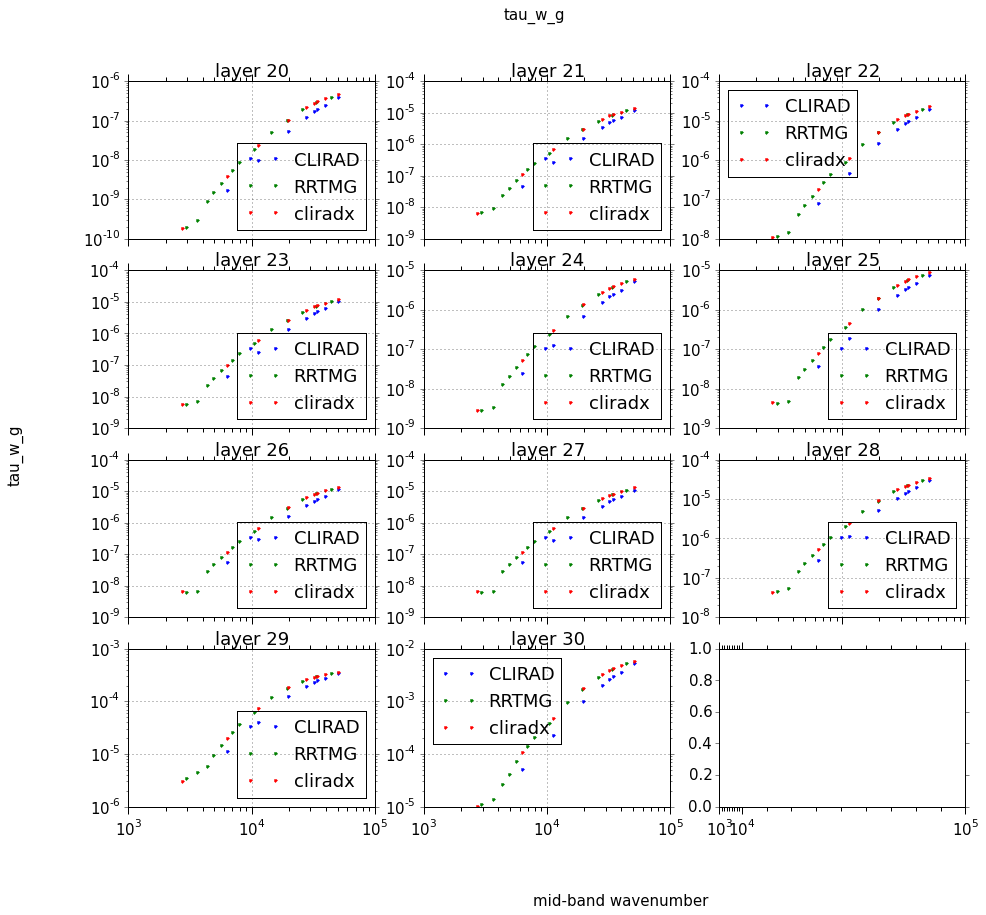

In [324]:
print('''
cliradx is interpolated from RRTMG using the same cubicsplint Fortran routine but compiled with f2py
''')

plt_RRTMG_vs_CLIRAD(layers = range(20, 30 + 1),
                    optical_prop = 'tau_w_g')

In [323]:
print('''basic stats on optical properties written out from subroutine 
aer_optics_rrtmg_to_clirad() during crashed run''')
stats_summary_AER_OPTICS_RRTMG_TO_CLIRAD()

basic stats on optical properties written out from subroutine 
aer_optics_rrtmg_to_clirad() during crashed run

model:  rrtmg    sortedby:  wavenumber
                tau         tau_w       tau_w_g       tau_w_f
count  4.340000e+02  4.340000e+02  4.340000e+02  4.340000e+02
mean   6.784050e-05  2.989934e-02  2.746000e-02  2.333422e-02
std    5.658844e-04  1.636117e-01  1.503483e-01  1.277972e-01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    6.027000e-07  3.411250e-07  1.175750e-07  3.925000e-08
max    8.068663e-03  9.250000e-01  8.500000e-01  7.225000e-01

model:  rrtmg    sortedby:  band index
                tau         tau_w       tau_w_g       tau_w_f
count  4.340000e+02  4.340000e+02  4.340000e+02  4.340000e+02
mean   6.784050e-05  2.989934e-02  2.746000e-02  2.333422e-02
std    5.658844e-04  1.636117e-01  1.503483e-01  1.277972e-01
min

In [196]:
HTML('''
<script>
show_code = true;
function code_toggle() {
if (show_code) {$('div.input').hide();} else {$('div.input').show();}
show_code = !show_code
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
''')